# Predicting LendingClub Loan Charge-offs from Initial Listing Data


**June 14, 2018**

## Table of Contents

* [1. Introduction](#1)
 * [1.1 References](#1.1)
* [2. Import the Data](#2)
* [3. Response Variable](#3)
* [4. Limit the Feature Space](#4)
 * [4.1 Drop features missing more than 30% data](#4.1)
 * [4.2 Only keep loan features known to potential investors](#4.2)
* [5. Pre-processing and Exploratory Analysis](#5)
* [6. More Pre-processing](#6)
 * [6.1 Convert loan status to 0/1 charge-off indicator](#6.1)
 * [6.2 Create dummy variables](#6.2)
 * [6.3 Train/test split](#6.3)
* [7. Linear Dependence of Charge-off on the Predictors](#7)
* [8. Model Training and Testing](#8)
 * [8.1 Logistic regression with SGD training](#8.1)
 * [8.2 Support Vector Machine with SGD training](#8.2)
 * [8.3(a) Random forest classifier](#8.3(a))
 * [8.3(b) Random forest with few attributes](#8.3(b))
 * [8.4 k-nearest neighbors](#8.4)
 * [8.5 Neural Network](#8.5)
 * [8.6 Tune hyperparameters on the chosen model more finely](#8.6)
 * [8.7 Test set evaluation](#8.7)
* [9. Conclusion](#9)

# 1. Introduction
<a id="1"></a>

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will attempt to only use data available to investors via the LendingClub loan listing, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan listing (the loan amount, loan purpose, loan grade, interest rate, installment, etc.). Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

## 1.1 References
<a id="1.1"></a>

* LendingClub information
 * [LendingClub website](https://www.lendingclub.com/)
 * [LendingClub Wikipedia page](https://en.wikipedia.org/wiki/Lending_Club)
* Datasets
 * [LendingClub statistics](https://www.lendingclub.com/info/download-data.action) - Original data source, aggregated on Kaggle
 * [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle
 * [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another LendingClub dataset on Kaggle, not used in this project
* This project
 * [Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data)
 * [GitHub repo](https://github.com/jgcorliss/lending-club)

# 2. Import the Data
<a id="2"></a>

In [195]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe:

In [196]:
#loans = pd.read_csv('../input/accepted_2007_to_2018Q2.csv.gz', compression='gzip', low_memory=True)
#Download the data from (https://www.kaggle.com/wordsforthewise/lending-club) accepted_2007_to_2018Q4.csv or access the file uploaded
#The path should be given by where you stored the csv file. The path given below is the path where I stored the CSV file.

loans = pd.read_csv('C:/Users/Naveena/Documents/Data Mining and Analysis for Managers/Group project 3/accepted-200000.csv')

C:\Users\Naveena\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info:

In [197]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Columns: 151 entries, id to settlement_term
dtypes: float64(70), int64(46), object(35)
memory usage: 230.4+ MB


There are 199,999 rows and 151 variables. The size of the dataset is more than 230.4 MB.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [198]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
39624,31567173,NaN,15000,15000,15000,60 months,16.99,372.71,D,D3,Manufacturing Manager,3 years,MORTGAGE,104000.0,Source Verified,Oct-14,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=31567173,NaN,home_improvement,Home improvement,060xx,CT,8.31,0,Aug-85,700,704,1,33.0,60.0,8,1,1473,29.5,15,w,7272.91,7272.91,13776.11000,13776.11,7727.09,6049.02,0.0,0.0,0.0,Nov-17,372.71,Jan-18,Dec-17,734,730,0,36.0,1,Individual,NaN,NaN,NaN,0,82,248829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,NaN,NaN,NaN,2,31104.0,NaN,NaN,0,0,31.0,350,8,1,3,NaN,33.0,1.0,33.0,1,0,2,0,4,2,3,8,2,8,0.0,0,0,2,53.3,NaN,0,0,327390,26109,0,28578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
179320,14338171,NaN,13200,13200,13200,60 months,15.61,318.27,C,C5,Regional Vice President,10+ years,RENT,51000.0,Source Verified,Apr-14,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=14338171,NaN,debt_consolidation,Debt consolidation,329xx,FL,11.06,0,Jun-03,665,669,0,NaN,89.0,5,1,9686,69.2,11,f,0.00,0.00,17903.89858,17903.90,13200.00,4703.90,0.0,0.0,0.0,Feb-17,7400.99,NaN,Dec-17,759,755,0,NaN,1,Individual,NaN,NaN,NaN,0,0,27529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000,NaN,NaN,NaN,2,5506.0,3136.0,74.9,0,0,121.0,125,13,7,2,13.0,NaN,23.0,NaN,0,3,4,3,3,3,4,6,4,5,0.0,0,0,1,100.0,66.7,1,0,33024,27529,12500,19024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
187823,131983

# 3. Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [199]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid            142730
Charged Off            32691
Current                22685
Late (31-120 days)      1147
In Grace Period          495
Late (16-30 days)        247
Default                    4
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [200]:
help(loans.loc)

Help on _LocIndexer in module pandas.core.indexing object:

class _LocIndexer(_LocationIndexer)
 |  Access a group of rows and columns by label(s) or a boolean array.
 |  
 |  ``.loc[]`` is primarily label based, but may also be used with a
 |  boolean array.
 |  
 |  Allowed inputs are:
 |  
 |  - A single label, e.g. ``5`` or ``'a'``, (note that ``5`` is
 |    interpreted as a *label* of the index, and **never** as an
 |    integer position along the index).
 |  - A list or array of labels, e.g. ``['a', 'b', 'c']``.
 |  - A slice object with labels, e.g. ``'a':'f'``.
 |  
 |    .. warning:: Note that contrary to usual python slices, **both** the
 |        start and the stop are included
 |  
 |  - A boolean array of the same length as the axis being sliced,
 |    e.g. ``[True, False, True]``.
 |  - A ``callable`` function with one argument (the calling Series, DataFrame
 |    or Panel) and that returns valid output for indexing (one of the above)
 |  
 |  See more at :ref:`Selection 

In [201]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [202]:
loans.shape

(175421, 151)

There are 175,421 loans remaining. Check that the statuses are as expected:

In [203]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     142730
Charged Off     32691
Name: loan_status, dtype: int64

Status counts as percentages:

In [204]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.813643
Charged Off    0.186357
Name: loan_status, dtype: float64

About 81% of the remaining loans have been fully paid and 19% have charged off, so we have a somewhat unbalanced classification problem.

# 4. Limit the Feature Space
<a id="4"></a>

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

Definitions of the features are given in the LendingClub Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## 4.1 Drop features missing more than 30% data
<a id="4.1"></a>

First calculate the percentage of missing data for each feature:

In [205]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Top 10 features missing the most data:

In [206]:
missing_fractions.head(10)

inq_fi                      1.0
revol_bal_joint             1.0
sec_app_num_rev_accts       1.0
sec_app_open_act_il         1.0
sec_app_revol_util          1.0
sec_app_open_acc            1.0
sec_app_mort_acc            1.0
sec_app_inq_last_6mths      1.0
sec_app_earliest_cr_line    1.0
sec_app_fico_range_high     1.0
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

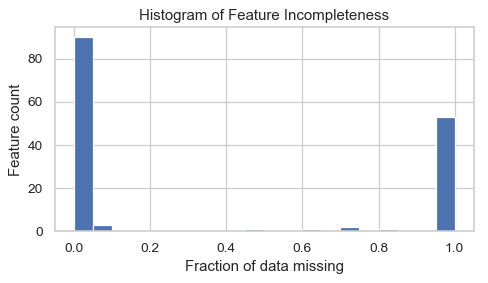

In [207]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;60%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [208]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [209]:
len(drop_list)

58

Drop these features:

In [210]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [211]:
loans.shape

(175421, 93)

## 4.2 Only keep loan features known to potential investors
<a id="4.2"></a>

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [212]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [213]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [214]:
len(keep_list)

31

The list of features to drop is any feature not in `keep_list`:

In [215]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [216]:
len(drop_list)

62

Drop these features:

In [217]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [218]:
loans.shape

(175421, 31)

# 5. Pre-processing and Exploratory Analysis
<a id="5"></a>

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [219]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [220]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## 5.1 id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

In [221]:
loans['id'].sample(5)

71732     28102621
37558     32430270
64532     28844007
116960    20079180
18282     34924521
Name: id, dtype: int64

Are all the IDs unique?

In [222]:
loans['id'].describe()

count    1.754210e+05
mean     2.353830e+07
std      7.741540e+06
min      5.716700e+04
25%      1.645309e+07
50%      2.241382e+07
75%      3.029508e+07
max      3.809811e+07
Name: id, dtype: float64

Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [223]:
loans.drop('id', axis=1, inplace=True)

## 5.2 loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [224]:
loans['loan_amnt'].describe()

count    175421.000000
mean      14159.529788
std        8364.416083
min        1000.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from $1,000 to $35,000, with a median of $12,000.

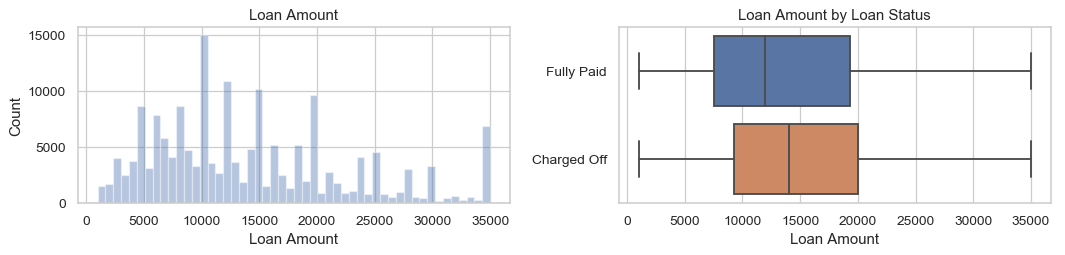

In [225]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [226]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,15298.158515,8365.163736,1000.0,9250.0,14000.0,20000.0,35000.0
Fully Paid,142730.0,13898.737301,8342.428948,1000.0,7500.0,12000.0,19350.0,35000.0


## 5.3 term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [227]:
loans['term'].value_counts(dropna=False)

 36 months    135928
 60 months     39493
Name: term, dtype: int64

Convert `term` to integers.

In [228]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [229]:
loans['term'].value_counts(normalize=True)

36    0.774867
60    0.225133
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [230]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.138684
60    0.350442
Name: loan_status, dtype: float64

About 14% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

## 5.4 int_rate  Step for Data Understanding . 


Data Dictionary: "Interest Rate on the loan."

In [231]:
loans['int_rate'].describe()

count    175421.000000
mean         13.395569
std           4.330604
min           6.000000
25%          10.150000
50%          12.990000
75%          15.610000
max          26.060000
Name: int_rate, dtype: float64

Interest rates range from 6% to 26.06% (!) with a median of 12.99%.

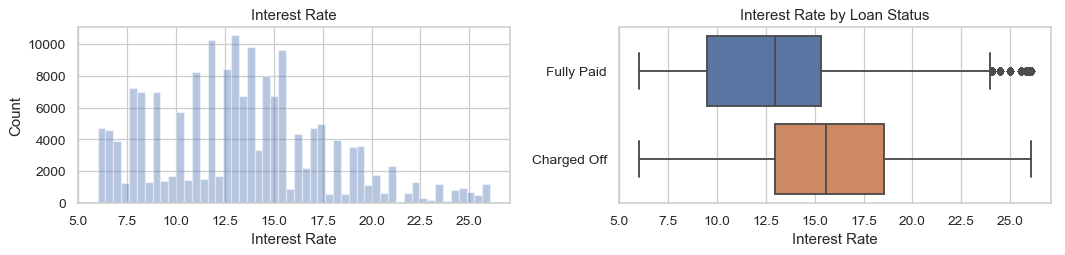

In [232]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [233]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,15.819228,4.252901,6.0,12.99,15.59,18.54,26.06
Fully Paid,142730.0,12.840453,4.153726,6.0,9.49,12.99,15.31,26.06


## 5.5 installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [234]:
loans['installment'].describe()

count    175421.000000
mean        433.309001
std         250.062811
min          23.360000
25%         251.560000
50%         373.220000
75%         570.840000
max        1409.990000
Name: installment, dtype: float64

Installments range from $23.36 to $1,409, with a median of $373.22.

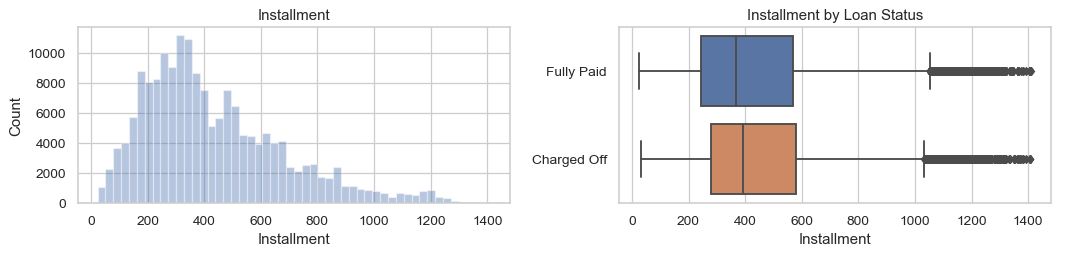

In [235]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [236]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,450.669499,239.545709,30.44,278.54,394.13,580.435,1408.13
Fully Paid,142730.0,429.332738,252.242681,23.36,245.16,367.74,568.010,1409.99


Loans that charge off have \$21.34 higher installments on average.

## 5.6 grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [237]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [238]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [239]:
loans.drop('grade', axis=1, inplace=True)

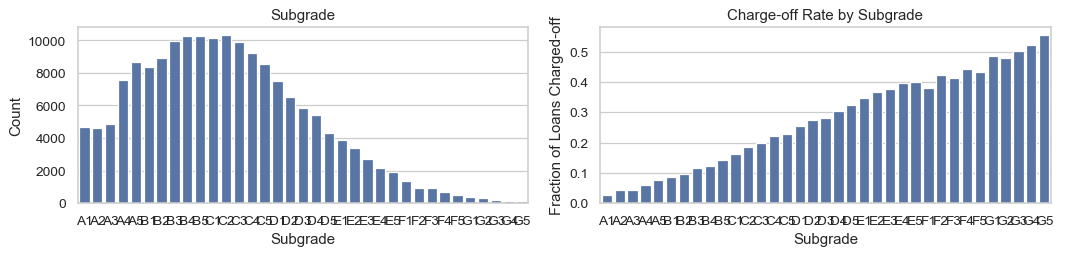

In [240]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## 5.7 emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [241]:
loans['emp_title'].describe()

count      166394
unique      59349
top       Teacher
freq         3279
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [242]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## 5.8 emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [243]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year       11174
10+ years    57590
2 years      15556
3 years      13793
4 years      10371
5 years       9612
6 years       8799
7 years       9711
8 years       8907
9 years       7103
< 1 year     13788
NaN           9017
Name: emp_length, dtype: int64

Note there are 9,017 loans without data on the length of employment.

Convert `emp_length` to integers:

In [244]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [245]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [246]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [247]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [248]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     13788
1.0     11174
2.0     15556
3.0     13793
4.0     10371
5.0      9612
6.0      8799
7.0      9711
8.0      8907
9.0      7103
10.0    57590
NaN      9017
Name: emp_length, dtype: int64

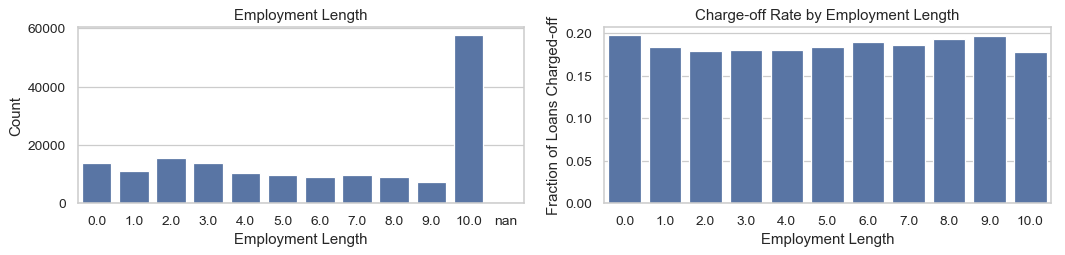

In [249]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## 5.9 home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [250]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    86633
RENT        71430
OWN         17357
ANY             1
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [251]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [252]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    86633
RENT        71430
OWN         17357
OTHER           1
Name: home_ownership, dtype: int64

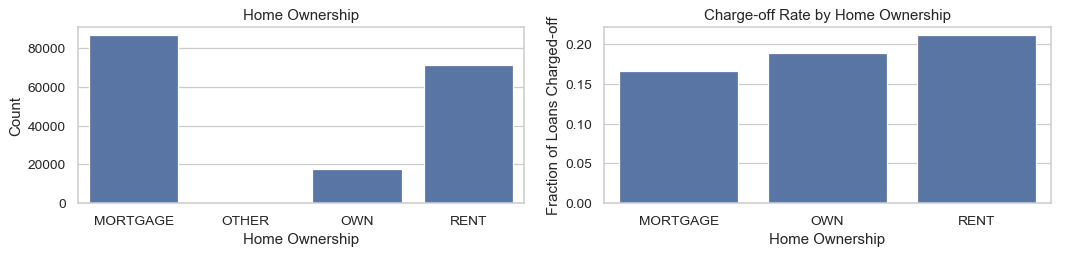

In [253]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [254]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.165676
OWN         0.188742
RENT        0.210864
Name: loan_status, dtype: float64

## 5.10 annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [255]:
loans['annual_inc'].describe()

count    1.754210e+05
mean     7.397439e+04
std      5.393443e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      9.000000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64

Annual income ranges from $3,000 to $7,500,000, with a median of $63,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [256]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [257]:
loans.drop('annual_inc', axis=1, inplace=True)

In [258]:
loans['log_annual_inc'].describe()

count    175421.000000
mean          4.804152
std           0.230515
min           3.477266
25%           4.653222
50%           4.799347
75%           4.954247
max           6.875061
Name: log_annual_inc, dtype: float64

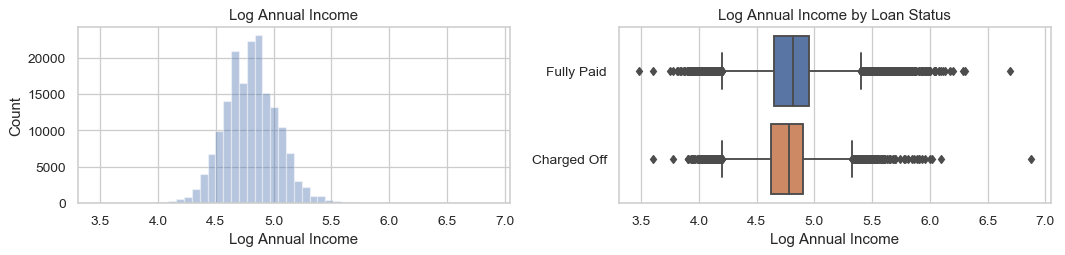

In [259]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [260]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,4.770070,0.220750,3.602169,4.623260,4.778064,4.903095,6.875061
Fully Paid,142730.0,4.811958,0.231991,3.477266,4.653222,4.812920,4.954247,6.690196


## 5.11 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

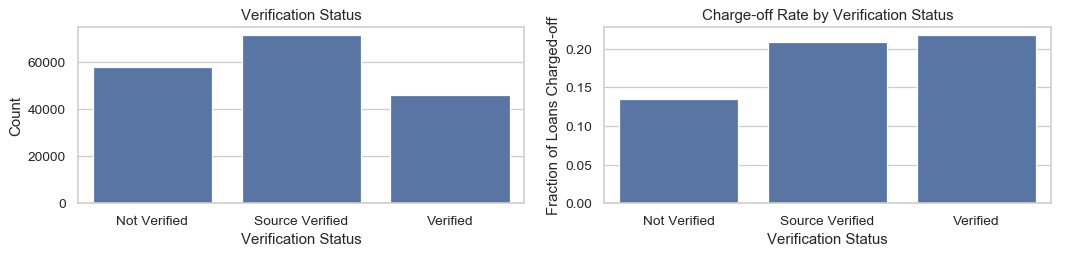

In [261]:
plot_var('verification_status', 'Verification Status', continuous=False)

People's whose income has been verified by [Lending Club] and whose income source was verified had higher probabililty of loans being charged off.

In [262]:
loans.groupby('verification_status')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

verification_status
Not Verified       0.134457
Source Verified    0.208632
Verified           0.217341
Name: loan_status, dtype: float64

## 5.12 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

## 5.13 purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [263]:
loans['purpose'].value_counts()

debt_consolidation    106366
credit_card            40094
home_improvement        9893
other                   8317
major_purchase          3019
medical                 1823
small_business          1631
car                     1468
moving                  1119
vacation                 996
house                    592
renewable_energy          96
wedding                    7
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [264]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
car                   0.138283
credit_card           0.157904
home_improvement      0.165471
major_purchase        0.173236
vacation              0.177711
other                 0.189612
medical               0.195283
debt_consolidation    0.197432
renewable_energy      0.218750
house                 0.224662
moving                0.246649
small_business        0.280196
Name: loan_status, dtype: float64

Notice that only 14% of completed loans for car have charged-off, but 28% of completed small business loans have charged-off. Also, wedding loans have been completely paid off.

## 5.14 title

Data Dictionary: "The loan title provided by the borrower."

In [265]:
loans['title'].describe()

count                 175421
unique                    33
top       Debt consolidation
freq                  106416
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [266]:
loans['title'].value_counts().head(10)

Debt consolidation         106416
Credit card refinancing     40027
Home improvement             9897
Other                        8310
Major purchase               3013
Medical expenses             1827
Business                     1630
Car financing                1471
Moving and relocation        1122
Vacation                      993
Name: title, dtype: int64

There are 33 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [267]:
loans.drop('title', axis=1, inplace=True)

## 5.15 zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [268]:
loans['zip_code'].sample(5)

121443    951xx
194646    333xx
194641    611xx
190045    820xx
111146    450xx
Name: zip_code, dtype: object

In [269]:
loans['zip_code'].nunique()

860

In [270]:
loans['addr_state'].sample(5)

153919    MD
104325    MD
52045     FL
123930    CO
183255    NC
Name: addr_state, dtype: object

In [271]:
loans['addr_state'].nunique()

47

There are a lot of different zip codes, so let's just keep the state column.

In [272]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [273]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.124000
NH    0.128878
VT    0.141791
KS    0.144275
OR    0.144895
CO    0.147849
WA    0.150724
CT    0.155547
SC    0.158166
WV    0.161036
IL    0.163110
WI    0.166880
WY    0.170561
UT    0.172387
GA    0.172737
MT    0.175407
CA    0.178629
TX    0.179055
MA    0.181701
AZ    0.183488
AK    0.185780
MI    0.186452
NJ    0.186726
RI    0.188557
SD    0.190104
MD    0.190115
NC    0.192242
MN    0.193095
OH    0.195034
FL    0.197481
VA    0.198696
IN    0.200263
KY    0.201397
NY    0.204441
NM    0.205205
HI    0.205618
PA    0.206992
MO    0.208514
AR    0.210884
LA    0.212211
NV    0.216293
TN    0.217131
AL    0.225333
OK    0.226512
DE    0.226531
MS    0.237186
Name: loan_status, dtype: float64

The charge-off rate ranges from 12.4% in Washington, DC to 23.72% in Mississippi.

## 5.16 dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [274]:
loans['dti'].describe()

count    175421.000000
mean         17.928268
std           8.095209
min           0.000000
25%          11.850000
50%          17.460000
75%          23.660000
max          39.990000
Name: dti, dtype: float64

There are several outliers that mess up our default plots.

Text(0.5, 1.0, 'Debt-to-income Ratio')

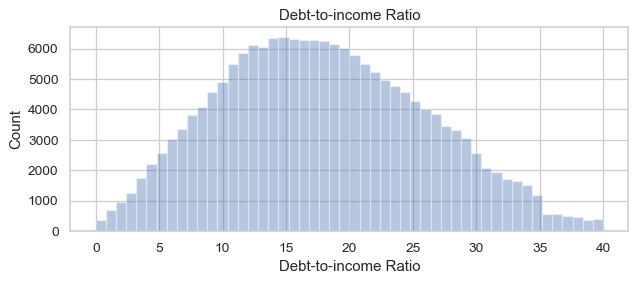

In [275]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull(), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [276]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,19.744853,8.185955,0.0,13.68,19.60,25.74,39.99
Fully Paid,142730.0,17.512195,8.016578,0.0,11.50,16.99,23.14,39.99


Completed loans that are charged off tend to have higher debt-to-income ratios.

## 5.17 earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [277]:
loans['earliest_cr_line'].sample(5)

188598    Sep-01
83165     Jan-94
144655    Sep-08
26464     Nov-01
90122     Apr-05
Name: earliest_cr_line, dtype: object

In [278]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [279]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-2:]))

In [280]:
loans['earliest_cr_line'].describe()

count    175421.000000
mean         50.242616
std          44.675006
min           0.000000
25%           3.000000
50%          79.000000
75%          95.000000
max          99.000000
Name: earliest_cr_line, dtype: float64

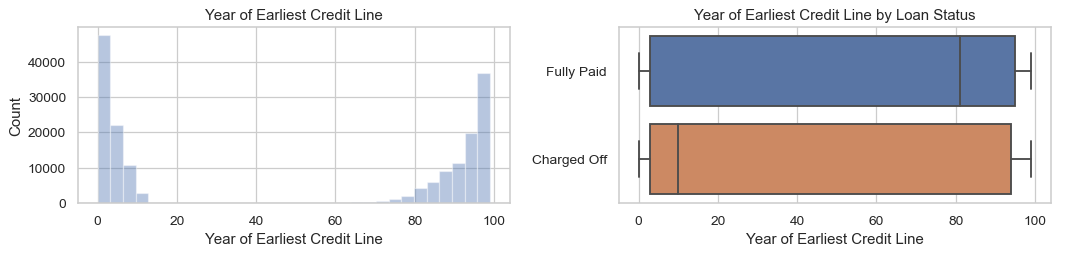

In [281]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## 5.18 fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [282]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,175421.000000,175421.000000
mean,692.539348,696.539405
std,29.630372,29.630666
min,660.000000,664.000000
25%,670.000000,674.000000
50%,685.000000,689.000000
75%,705.000000,709.000000
max,845.000000,850.000000


Check the Pearson correlation between these values:

In [283]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [284]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [285]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

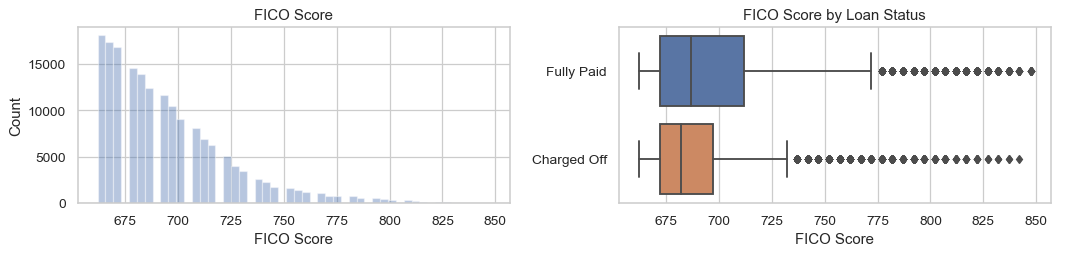

In [286]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [287]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,687.288306,23.659185,662.0,672.0,682.0,697.0,842.0
Fully Paid,142730.0,696.200168,30.595007,662.0,672.0,687.0,712.0,847.5


Loans that charge off have a FICO score 8.911862 points lower on average.

## 5.19 open_acc

Data Dictionary: "The number of open credit lines in the borrower's credit file."

Text(0.5, 1.0, 'Number of Open Credit Lines')

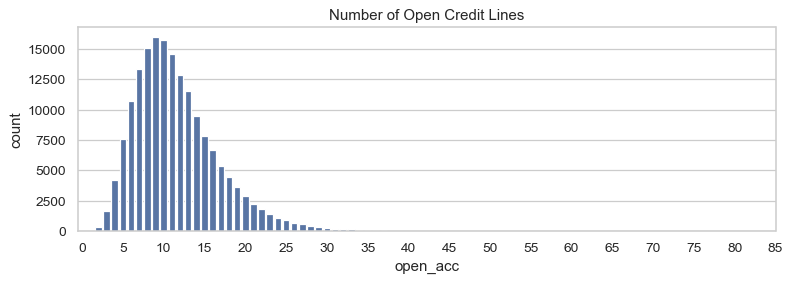

In [288]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [289]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,11.958857,5.426800,0.0,8.0,11.0,15.0,76.0
Fully Paid,142730.0,11.541323,5.257441,1.0,8.0,11.0,14.0,84.0


There isn't a lot of difference in number of credit lines between charged off and fully paid loans. It is very minimal.

## 5.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [290]:
loans['pub_rec'].value_counts().sort_index()

0     144022
1      26352
2       3387
3       1005
4        323
5        164
6         82
7         38
8         16
9         10
10         9
11         5
12         2
15         1
16         1
18         2
19         1
40         1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [291]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,0.235080,0.618033,0.0,0.0,0.0,0.0,40.0
Fully Paid,142730.0,0.223072,0.582017,0.0,0.0,0.0,0.0,18.0


## 5.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [292]:
loans['revol_bal'].describe()

count    1.754210e+05
mean     1.602978e+04
std      2.165516e+04
min      0.000000e+00
25%      5.975000e+03
50%      1.108800e+04
75%      1.972600e+04
max      2.560703e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [293]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [294]:
loans.drop('revol_bal', axis=1, inplace=True)

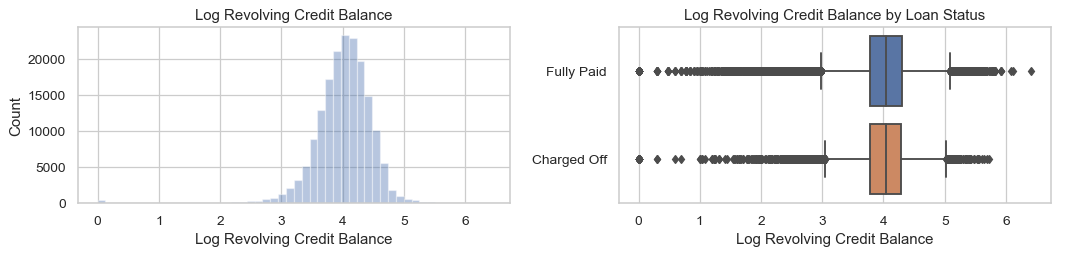

In [295]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [296]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,4.005679,0.446377,0.0,3.786006,4.045127,4.281499,5.715439
Fully Paid,142730.0,4.011170,0.472218,0.0,3.774006,4.044794,4.298547,6.408359


There isn't a large difference in the means.

## 5.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [297]:
loans['revol_util'].describe()

count    175329.000000
mean         54.677114
std          23.297539
min           0.000000
25%          37.600000
50%          55.100000
75%          72.400000
max         892.300000
Name: revol_util, dtype: float64

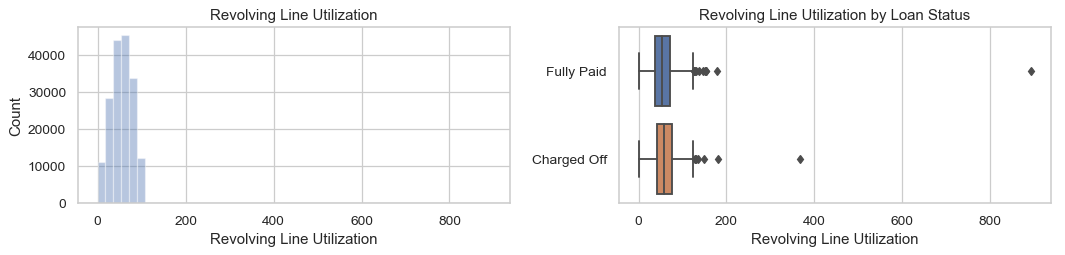

In [298]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [299]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32669.0,57.746191,22.567358,0.0,41.9,58.6,75.0,366.6
Fully Paid,142660.0,53.974299,23.405065,0.0,36.7,54.2,71.8,892.3


## 5.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

Text(0.5, 1.0, 'Total Number of Credit Lines')

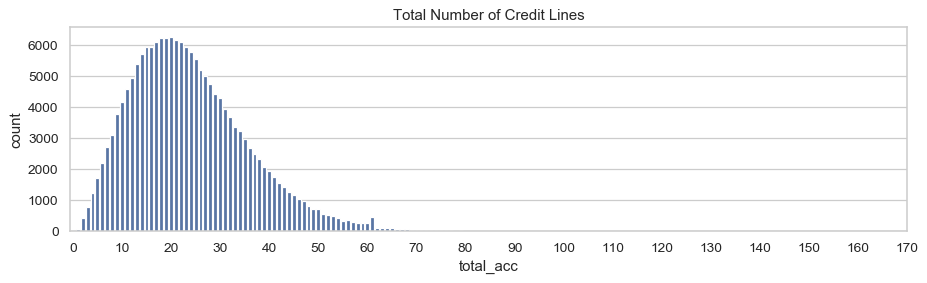

In [300]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [301]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,25.767948,12.151543,2.0,17.0,24.0,33.0,119.0
Fully Paid,142730.0,25.879114,11.971974,2.0,17.0,24.0,33.0,156.0


No large differences here.

## 5.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." W means 'whole' loans. I'm not sure what F means.

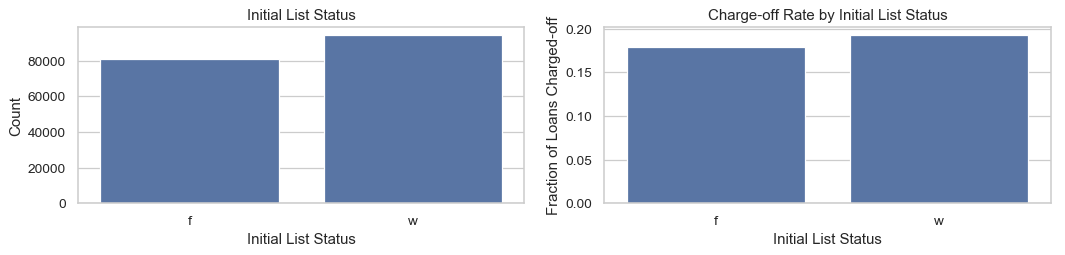

In [302]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## 5.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [303]:
loans['application_type'].value_counts()

Individual    175421
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [304]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.186357
Name: loan_status, dtype: float64

## 5.26 mort_acc

Data Dictionary: "Number of mortgage accounts."

In [305]:
loans['mort_acc'].describe()

count    175421.000000
mean          1.794050
std           2.138689
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          34.000000
Name: mort_acc, dtype: float64

Not sure how someone can have 34 mortgage accounts...but apparently they do. Check the top 10 values:

In [306]:
loans['mort_acc'].value_counts().head(10)

0    69936
1    28399
2    24302
3    18698
4    13879
5     8865
6     5329
7     2809
8     1474
9      735
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [307]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,1.538374,1.993969,0.0,0.0,1.0,3.0,22.0
Fully Paid,142730.0,1.852610,2.166241,0.0,0.0,1.0,3.0,34.0


Individuals who pay off their loans are more likely to have several mortgage accounts.

## 5.27 pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [308]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0     152700
1      21397
2       1025
3        224
4         49
5         18
6          2
7          5
12         1
Name: pub_rec_bankruptcies, dtype: int64

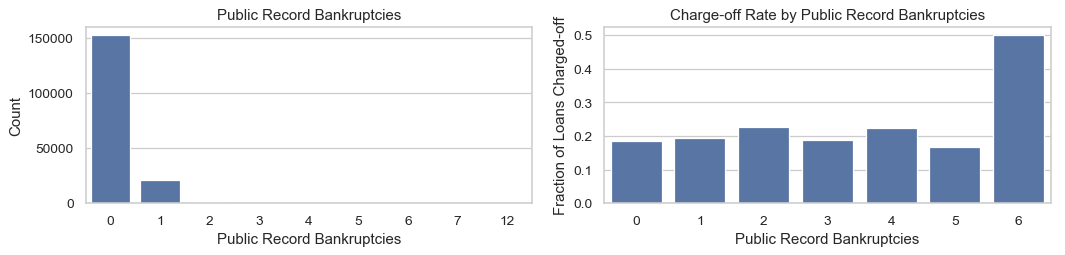

In [309]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# 6. More Pre-processing
<a id="6"></a>

## 6.1 Convert loan status to 0/1 charge-off indicator
<a id="6.1"></a>

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [310]:
loans.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal
0,15000,60,12.39,336.64,C1,10.0,RENT,Source Verified,Dec-14,Fully Paid,debt_consolidation,VA,12.03,94,6,0,29.0,17,w,Individual,0,0,4.892100,752.0,5.139907
1,10400,36,6.99,321.08,A3,8.0,MORTGAGE,Not Verified,Dec-14,Charged Off,credit_card,CA,14.92,89,17,0,31.6,36,w,Individual,1,0,4.763435,712.0,3.787744
2,21425,60,15.59,516.36,D1,6.0,RENT,Source Verified,Dec-14,Fully Paid,credit_card,MO,18.49,3,10,0,76.2,35,w,Individual,0,0,4.804827,687.0,4.214181
4,7650,36,13.66,260.20,C3,0.0,RENT,Source Verified,Dec-14,Charged Off,debt_consolidation,AZ,34.81,2,11,0,91.9,20,f,Individual,0,0,4.698979,687.0,4.225903
5,9600,36,13.66,326.53,C3,10.0,RENT,Source Verified,Dec-14,Fully Paid,debt_consolidation,NJ,25.81,92,12,0,59.4,44,f,Individual,0,0,4.838855,682.0,4.214552


In [311]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [312]:
loans.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,15000,60,12.39,336.64,C1,10.0,RENT,Source Verified,Dec-14,debt_consolidation,VA,12.03,94,6,0,29.0,17,w,Individual,0,0,4.892100,752.0,5.139907,0
1,10400,36,6.99,321.08,A3,8.0,MORTGAGE,Not Verified,Dec-14,credit_card,CA,14.92,89,17,0,31.6,36,w,Individual,1,0,4.763435,712.0,3.787744,1
2,21425,60,15.59,516.36,D1,6.0,RENT,Source Verified,Dec-14,credit_card,MO,18.49,3,10,0,76.2,35,w,Individual,0,0,4.804827,687.0,4.214181,0
4,7650,36,13.66,260.20,C3,0.0,RENT,Source Verified,Dec-14,debt_consolidation,AZ,34.81,2,11,0,91.9,20,f,Individual,0,0,4.698979,687.0,4.225903,1
5,9600,36,13.66,326.53,C3,10.0,RENT,Source Verified,Dec-14,debt_consolidation,NJ,25.81,92,12,0,59.4,44,f,Individual,0,0,4.838855,682.0,4.214552,0


## 6.2 Create dummy variables
<a id="6.2"></a>

How many variables do we currently have?

In [313]:
loans.shape

(175421, 25)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [314]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [315]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

emp_length    0.051402
revol_util    0.000524
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [316]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [317]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [318]:
loans.shape

(175421, 116)

Check our data with the new dummy variables:

In [319]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
76645,35000,60,14.99,832.47,8.0,Sep-14,13.57,0,7,0,95.4,15,5,0,5.127108,717.0,4.559428,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74323,14125,60,19.52,370.47,3.0,Oct-14,19.47,1,7,0,90.4,16,2,0,4.556315,662.0,3.933740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
150728,3000,36,12.99,101.07,4.0,May-14,10.78,0,8,0,22.9,12,0,0,4.591076,697.0,3.762153,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
57858,12600,60,9.17,262.60,3.0,Oct-14,9.00,6,10,0,15.0,38,0,0,4.929424,712.0,3.890309,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
130381,8000,36,8.39,252.14,10.0,Jul-14,24.05,92,20,0,22.5,34,2,0,4.778158,757.0,3.961658,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 6.3 Train/test split
<a id="6.3"></a>

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [320]:
loans['issue_d'].sample(5)

185284    Apr-14
5726      Dec-14
113502    Jul-14
148336    Jun-14
136610    Jun-14
Name: issue_d, dtype: object

Are there any missing values?

In [321]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [322]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [323]:
loans['issue_d'].sample(5)

46849    2014-10-01
111736   2014-07-01
49576    2014-10-01
68995    2014-10-01
16657    2014-11-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [324]:
loans['issue_d'].describe()

count                  175421
unique                     10
top       2014-10-01 00:00:00
freq                    33699
first     2014-03-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

In [325]:
loans['issue_d'].head(8)

0   2014-12-01
1   2014-12-01
2   2014-12-01
4   2014-12-01
5   2014-12-01
6   2014-12-01
7   2014-12-01
8   2014-12-01
Name: issue_d, dtype: datetime64[ns]

There are only 10 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in Marcch 2014, and the most recent loans were issued in December 2014. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans funded in each year?

Text(0.5, 1.0, 'Loans Funded per Year')

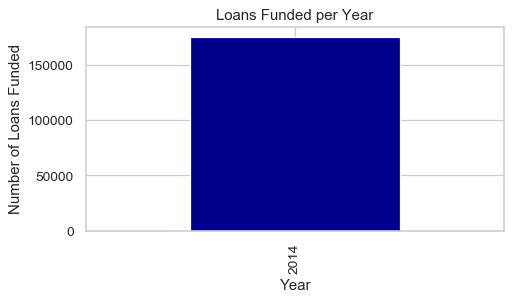

In [326]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [327]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [328]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    175421
Number of loans in the full dataset: 175421


What is the test size?

In [329]:
loans_test.shape[0] / loans.shape[0]

0.16799014941198603

The partition looks good, so we can delete the original `loans` dataframe:

In [330]:
del loans

Let's look at the summary statistics of the issue dates in the train and test sets:

In [331]:
loans_train['issue_d'].describe()

count                  145952
unique                      8
top       2014-10-01 00:00:00
freq                    33699
first     2014-03-01 00:00:00
last      2014-10-01 00:00:00
Name: issue_d, dtype: object

In [332]:
loans_test['issue_d'].describe()

count                   29469
unique                      2
top       2014-11-01 00:00:00
freq                    21186
first     2014-11-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from March 2014 to October 2014. The test set includes loans from November 2014 to December 2014.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [333]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:
Because the input dataset is really big,  I only take 10% DATA for training.  You can use 100% data. 

In [334]:
#subsetloans_train=loans_train.sample(frac=0.1)

#y_train = loans_train['charged_off']
y_train = loans_train['charged_off']

y_test = loans_test['charged_off']

In [335]:
#X_train = loans_train.drop('charged_off', axis=1)
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)
print(X_train.shape)
print(X_test.shape)

(145952, 114)
(29469, 114)


In [336]:
del loans_train, loans_test

# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

On the training set, we compute the Pearson correlation, F-statistics and $p$ value of each predictor with the response variable `charged_off`.

In [337]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [338]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

$F$-statistics:

In [339]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [340]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [341]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [342]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,int_rate,0.265011,11024.449979,0.000000e+00
1,term,0.228918,8071.240807,0.000000e+00
2,fico_score,-0.116294,2000.922475,0.000000e+00
3,dti,0.105260,1635.207864,0.000000e+00
4,log_annual_inc,-0.071973,759.969998,7.326115e-167
5,sub_grade_A4,-0.066890,655.952009,2.370157e-144
6,loan_amnt,0.065388,626.694421,5.128860e-138
7,sub_grade_E2,0.064937,618.053509,3.814137e-136
8,revol_util,0.062338,569.067423,1.561111e-125
9,sub_grade_A5,-0.062114,565.269672,1.038067e-124


The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [343]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
94,purpose_wedding,-0.003317,1.605805,0.205084
95,purpose_other,0.002868,1.200165,0.273291
96,sub_grade_C2,-0.002331,0.793471,0.373054
97,addr_state_HI,0.002047,0.611670,0.434161
98,addr_state_MN,0.001975,0.569402,0.450498
99,home_ownership_OWN,0.001940,0.549953,0.458338
100,addr_state_RI,-0.001906,0.529984,0.466615
101,addr_state_UT,-0.001708,0.425737,0.514089
102,addr_state_WY,-0.001636,0.390562,0.532005
103,addr_state_MI,-0.001378,0.277192,0.598548


It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

# 8. Model Training and Testing
<a id="8"></a>

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest
3. k-nearest neighbors

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [344]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

#SGD classifier and svc
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

#random forest
from sklearn.ensemble import RandomForestClassifier

#KNN
from sklearn.neighbors import KNeighborsClassifier

#Neural networking
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

## 8.1 Logistic regression with SGD training
<a id="8.1"></a>

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

The machine learning pipeline:

In [345]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [346]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [347]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [348]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0...ndom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__alpha': [1e-05, 0.01, 10], 'model__penalty': ['l1', 'l2']},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [349]:
grid_sgdlogreg.best_score_

0.7236387824216924

Best hyperparameters:

In [350]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

## 8.2 Support Vector Machine with SGD training
<a id="8.2"></a>

In [351]:
pipeline_sgdsvm = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

param_grid_sgdsvm = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2', 'elasticnet']
}

grid_sgdsvm = GridSearchCV(estimator=pipeline_sgdsvm, param_grid=param_grid_sgdsvm, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_sgdsvm.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0...ndom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__alpha': [1e-05, 0.01, 10], 'model__penalty': ['l1', 'l2', 'elasticnet']},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [352]:
grid_sgdsvm.best_score_

0.7199143974936802

In [353]:
grid_sgdsvm.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l1'}

## 8.3(a) Random forest classifier
<a id="8.3(a)"></a>

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [354]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy = False)),
    ('model', RandomForestClassifier(random_state=0)) 
])

param_grid_rfc = {
    'model__n_estimators':[100],
    'model__max_depth':[15],
    'model__min_samples_leaf':[4],
    'model__min_samples_split':[2]
  }

grid_rfc = GridSearchCV(estimator = pipeline_rfc, param_grid = param_grid_rfc, scoring = 'roc_auc', n_jobs = 1, pre_dispatch = 1, cv = 5, verbose = 1, return_train_score = False)

grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_...ors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__n_estimators': [100], 'model__max_depth': [15], 'model__min_samples_leaf': [4], 'model__min_samples_split': [2]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [355]:
#Mean cross-validated AUROC score of the random forest:
print(grid_rfc.best_score_)

0.7231379117474697


The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

Almost similar to logistic regression implemented before.

## 8.3(b) Random Forest Classifier with few attributes
<a id="8.3(b)"></a>

In [356]:
pipeline_rfc2 = Pipeline([
    ('imputer', SimpleImputer(copy = False)),
    ('model', RandomForestClassifier(random_state=0)) 
])

param_grid_rfc2 = {
    'model__n_estimators':[1000],
    'model__max_depth':[15]
  }

grid_rfc2 = GridSearchCV(estimator = pipeline_rfc2, param_grid = param_grid_rfc2, scoring = 'roc_auc', n_jobs = 1, pre_dispatch = 1, cv = 5, verbose = 1, return_train_score = False)

grid_rfc2.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_...ors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__n_estimators': [1000], 'model__max_depth': [15]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [357]:
grid_rfc2.best_score_

0.7240278905196015

Find each columns' gini importances that are greater than 0.01 and place those columns in a new dataframe, and run the random forest classifier again.

In [358]:
for feature in zip(X_train.columns, grid_rfc2.best_estimator_.named_steps['model'].feature_importances_>0.01):
    print(feature)

('loan_amnt', True)
('term', True)
('int_rate', True)
('installment', True)
('emp_length', True)
('dti', True)
('earliest_cr_line', True)
('open_acc', True)
('pub_rec', False)
('revol_util', True)
('total_acc', True)
('mort_acc', True)
('pub_rec_bankruptcies', False)
('log_annual_inc', True)
('fico_score', True)
('log_revol_bal', True)
('sub_grade_A2', False)
('sub_grade_A3', False)
('sub_grade_A4', False)
('sub_grade_A5', False)
('sub_grade_B1', False)
('sub_grade_B2', False)
('sub_grade_B3', False)
('sub_grade_B4', False)
('sub_grade_B5', False)
('sub_grade_C1', False)
('sub_grade_C2', False)
('sub_grade_C3', False)
('sub_grade_C4', False)
('sub_grade_C5', False)
('sub_grade_D1', False)
('sub_grade_D2', False)
('sub_grade_D3', False)
('sub_grade_D4', False)
('sub_grade_D5', False)
('sub_grade_E1', False)
('sub_grade_E2', False)
('sub_grade_E3', False)
('sub_grade_E4', False)
('sub_grade_E5', False)
('sub_grade_F1', False)
('sub_grade_F2', False)
('sub_grade_F3', False)
('sub_grade_F4

In [359]:
X_important_train = X_train[['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'dti', 'earliest_cr_line', 'open_acc', 'revol_util', 'total_acc', 'mort_acc', 'log_annual_inc', 'fico_score', 'log_revol_bal', 'home_ownership_RENT']]
X_important_test = X_test[['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'dti', 'earliest_cr_line', 'open_acc', 'revol_util', 'total_acc', 'mort_acc', 'log_annual_inc', 'fico_score', 'log_revol_bal', 'home_ownership_RENT']]

In [360]:
pipeline_rfc3_imp = Pipeline([
    ('imputer', SimpleImputer(copy = False)),
    ('model', RandomForestClassifier(random_state=0)) 
])

param_grid_rfc3_imp = {
    'model__n_estimators':[1000],
    'model__max_depth':[15]
  }

grid_rfc3_imp = GridSearchCV(estimator = pipeline_rfc3_imp, param_grid = param_grid_rfc3_imp, scoring = 'roc_auc', n_jobs = 1, pre_dispatch = 1, cv = 5, verbose = 1, return_train_score = False)

grid_rfc3_imp.fit(X_important_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_...ors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__n_estimators': [1000], 'model__max_depth': [15]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [361]:
grid_rfc3_imp.best_score_

0.7226477845051323

We see that there isn't much difference in the accuracy between important features and all the features, and also similar to the logistic regression accuracy.

## 8.4 k-nearest neighbors
<a id="8.4"></a>

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use PCA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [362]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('pca', PCA()), #for dimensionality reduction
    ('model', KNeighborsClassifier())
])

In [363]:
param_grid_knn = {
    'pca__n_components':[9],
    'model__n_neighbors':[125],
    'model__p':[2]
}

In [364]:
grid_knn = GridSearchCV(estimator = pipeline_knn, param_grid = param_grid_knn, scoring = 'roc_auc', n_jobs = 1, pre_dispatch = 1, cv = 5, verbose = 1, return_train_score = False)

In [365]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_s...i',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'pca__n_components': [9], 'model__n_neighbors': [125], 'model__p': [2]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [366]:
grid_knn.best_score_

0.7112787076907598

Best hyperparameters:

In [367]:
grid_knn.best_params_

{'model__n_neighbors': 125, 'model__p': 2, 'pca__n_components': 9}

9 PCA components are necessary for kNN to perform almost as well as random forest classifier!

## 8.5 Neural Networking
<a id="8.5"></a>

In [368]:
n_input = X_train.shape[1]
n_hidden = n_input

# Function to create model, required for KerasClassifier

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(n_hidden, input_dim=n_input, activation='sigmoid'))  
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(50, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create pipeline
pipeline_nn = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', KerasClassifier(build_fn=create_model, verbose=0))
])

# define the grid search parameters
param_grid_nn = {
    'model__batch_size' : [120, 150, 180, 200, 220],
    'model__epochs' : [10]
}

grid_nn = GridSearchCV(estimator=pipeline_nn, param_grid=param_grid_nn, n_jobs=-1, cv=5, scoring = 'roc_auc', pre_dispatch = 1, verbose = 1, return_train_score = False)
grid_nn.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 14.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022D908EAC50>)]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__batch_size': [120, 150, 180, 200, 220], 'model__epochs': [10]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [369]:
print(grid_nn.best_score_)

print(grid_nn.best_params_)

0.7254228985901662
{'model__batch_size': 120, 'model__epochs': 10}


## 8.6 Tune hyperparameters on the chosen model more finely
<a id="8.6"></a>

The three models performed quite similarly according to the AUROC:

In [370]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_sgdsvm.best_score_, '- Support Vector machine with SGD Classifier')
print(grid_rfc.best_score_, '- Random forest')
print(grid_rfc3_imp.best_score_, '- Random forest with important attributes')
print(grid_knn.best_score_, '- k-nearest neighbors')
print(grid_nn.best_score_, '- Neural Network')

Cross-validated AUROC scores
0.7236387824216924 - Logistic regression
0.7199143974936802 - Support Vector machine with SGD Classifier
0.7231379117474697 - Random forest
0.7226477845051323 - Random forest with important attributes
0.7112787076907598 - k-nearest neighbors
0.7254228985901662 - Neural Network


Neural Network squeaked out ahead; we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [371]:
from keras import regularizers

n_input = X_train.shape[1]
n_hidden = n_input

# Function to create model, required for KerasClassifier

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(n_hidden, input_dim=n_input, activation='sigmoid'))  
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(75, activation='sigmoid'))
    model.add(Dense(50, activation = 'sigmoid'))
    model.add(Dense(25, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create pipeline
pipeline_nn = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', KerasClassifier(build_fn=create_model, verbose=0))
])

# define the grid search parameters
param_grid_nn = {
    'model__batch_size' : [165],
    'model__epochs' : [10]
}

grid_nn = GridSearchCV(estimator=pipeline_nn, param_grid=param_grid_nn, n_jobs=-1, cv=5, scoring = 'roc_auc', pre_dispatch = 1, verbose = 1, return_train_score = False)
grid_nn.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022D90FB03C8>)]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__batch_size': [165], 'model__epochs': [10]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [372]:
grid_nn.best_score_

0.7249136442668659

Best hyperparameters:

In [373]:
grid_nn.best_params_

{'model__batch_size': 165, 'model__epochs': 10}

By some coincidence, the optimal hyperparameters here are similar as first grid search for neural networks.

## 8.7 Test set evaluation
<a id="8.7"></a>

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [374]:
from sklearn.metrics import roc_auc_score

In [375]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.7286444107034795

In [376]:
y_score = grid_sgdsvm.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.7222519385772543

In [377]:
y_score = grid_knn.predict_proba(X_test)[:,1]
print(y_score)
roc_auc_score(y_test, y_score)

[0.192 0.032 0.408 ... 0.208 0.136 0.288]


0.7207528852012207

In [378]:
y_score = grid_rfc.predict_proba(X_test)[:,1]
print(y_score)
roc_auc_score(y_test, y_score)

[0.19204534 0.05486522 0.37328735 ... 0.18447746 0.08805683 0.31333524]


0.730454104040717

In [379]:
y_score = grid_rfc3_imp.predict_proba(X_important_test)[:,1]
print(y_score)
roc_auc_score(y_test, y_score)

[0.23218173 0.05542272 0.36886202 ... 0.18408644 0.08246736 0.35883656]


0.7289725475310808

In [380]:
y_score = grid_nn.predict_proba(X_test)[:,1]
print(y_score)
roc_auc_score(y_test, y_score)

[0.1386477  0.0326353  0.38319576 ... 0.22134057 0.09055912 0.4849383 ]


0.7290261674526572

The test set AUROC score is somewhat higher than the cross-validated score (0.729).

# 9. Conclusion
<a id="9"></a>

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating five different models (logistic regression, SVM, random forest, k-nearest neighbors, and neural networks), we found that all five performed similarly according to a cross-validated AUROC score on the training data. We selected neural network (with batch size 165 and 10 epochs) because it was the fastest model to train, and this model obtained an AUROC score of 0.7291 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to linear measures of correlation between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.